In [1]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import tukey_hsd
import statsmodels.stats.multicomp as mc
from seaborn_qqplot import pplot
import re

In [2]:
# read in data set
rum = pd.read_csv('Data/rum.csv')
rum_price_adjust = rum[(rum['Price'] <= 1000) & (rum['Price'] > 10)]
rum.head()

16222

***
**Again, we will read in our rum data set and create a copy where we subset the data to contain all rums between 10 and 1000 Euros. This is to prevent skew with suspiciously low values rums and some crazy outliers on the high end.**

**First, I wanted to look at some statistical tests to see if there are significant differences in ratings between a few key categories (Country, Distillation Type, and Raw Material). For this, we will conduct an Analysis of Variance, ANOVA, test and check the underlying assumptions of this test.**

**ANOVA tests have 3 key assumptions:**

<ul>
  <li><b>Independent Observations</b></li>
  <li><b>Normally Distributed Residuals</b></li>
  <li><b>Common Variance Across Groups</b></li>
</ul>

**Since the underlying data represents self-reported data from many users, some of which are surely repeated, it isn't safe to say these are strictly independent. With that limitation in mind, we will use a large sample size and carry on with the analysis for educational curiosity, acknowledging this limitation. The other two assumptions will be more closely scrutinized.**

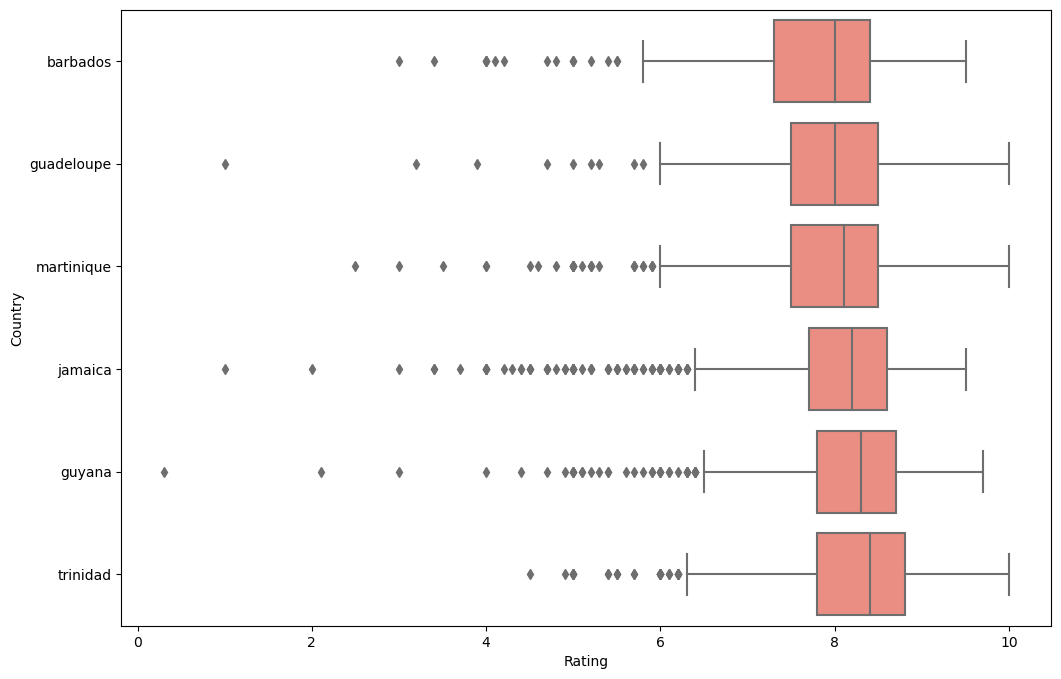

In [4]:
# set min observations
min_obs = 500

# subset data
rum_country_rating = rum[['Country', 'Rating']].dropna()
more_than_min = list(rum_country_rating['Country'].value_counts()[rum_country_rating['Country'].value_counts().values >= min_obs].index)
rum_country_rating = rum_country_rating[rum_country_rating['Country'].isin(more_than_min)].dropna()

# get ordered index values
mean_by_country = rum[rum['Country'].isin(more_than_min)].groupby(['Country'])['Rating'].mean().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y='Country', x='Rating', data=rum_country_rating, color='#fb8072', order=mean_by_country.index)
plt.show()

**Since the data set contains over 90 unique countries, we will focus on the ones with at least 500 observations. Looking at a basic box plot for the 6 top countries represented, we see some slight differences in rating. Are they statistically different though?**

In [42]:
modelCountry = ols("Rating ~ Country", data=rum_country_rating.dropna()).fit()
aov_tableCountry = sm.stats.anova_lm(modelCountry, typ=1)
aov_tableCountry

,df,sum_sq,mean_sq,F,PR(>F)
Country,5.0,82.112476,16.422495,20.484254,2.547907e-20
Residual,5477.0,4390.982847,0.801713,NaN,NaN


**The ANOVA test output shows a p-value well below 0.05, indicating at least one of the 6 groups has a statistically different mean value from the others. Assuming the assumptions hold, more on this next, at least 1 pairwise comparison is statistically different.**

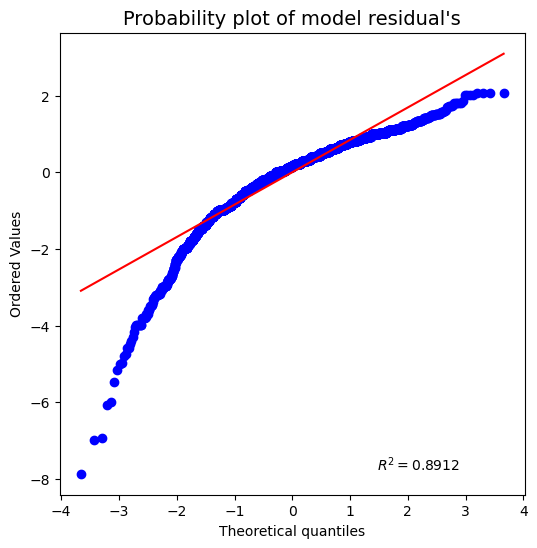


Levene Test for Variance P-Value: 0.7614567804623122



In [45]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelCountry.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()

levene_stat = stats.levene(rum['Rating'][rum['Country'] == 'barbados'].dropna(),
             rum['Rating'][rum['Country'] == 'guadeloupe'].dropna(),
             rum['Rating'][rum['Country'] == 'martinique'].dropna(),
             rum['Rating'][rum['Country'] == 'jamaica'].dropna(),
             rum['Rating'][rum['Country'] == 'guyana'].dropna(),
             rum['Rating'][rum['Country'] == 'trinidad'].dropna()
             )
print('')
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')
print('')

**To test the assumption of Normally distributed residuals, we plot a QQ-plot and check for a straight line. Here we see a clear pattern where the lower and upper end of the distribution of residuals clearly deviate from Normal. The Levene test checks for common variance between the different groups. A p-value of 0.76 indicates that we fail to reject the null hypothesis that the groups have common variance. Common variance was the only assumption met, and as such a different model or approach would be best for addressing our question. However, for fun and out of educational curiosity, we will perform a Tukey pairwise test to see which countries *maybe* have different means.**

In [43]:
rum_tukey_country = rum[['Rating', 'Country']].dropna()
rum_tukey_country = rum_tukey_country[rum_tukey_country['Country'].isin(['barbados', 'guadeloupe', 'martinique', 'jamaica', 'guyana', 'trinidad'])]

comp = mc.MultiComparison(rum_tukey_country['Rating'], rum_tukey_country['Country'])
tukey_country = comp.tukeyhsd()
tukey_country.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
barbados,guadeloupe,0.1335,0.1005,-0.0136,0.2805,False
barbados,guyana,0.3659,0.0,0.2372,0.4946,True
barbados,jamaica,0.191,0.0001,0.0699,0.3122,True
barbados,martinique,0.1719,0.0009,0.0492,0.2947,True
barbados,trinidad,0.3979,0.0,0.2581,0.5376,True
guadeloupe,guyana,0.2324,0.0,0.0968,0.3681,True
guadeloupe,jamaica,0.0576,0.798,-0.071,0.1861,False
guadeloupe,martinique,0.0385,0.9594,-0.0916,0.1686,False
guadeloupe,trinidad,0.2644,0.0,0.1182,0.4106,True
guyana,jamaica,-0.1749,0.0,-0.2819,-0.0678,True


**The above output tests each country pairwise to check for differences in means. As stated above, these results should be questioned due to failed assumptions of ANOVA analysis, however, we see differences between countries.**

***

**Next we will look at differences between the 3 most common types of distillation (Column, Pot, and Blended) stills and their potential differences in ratings.**

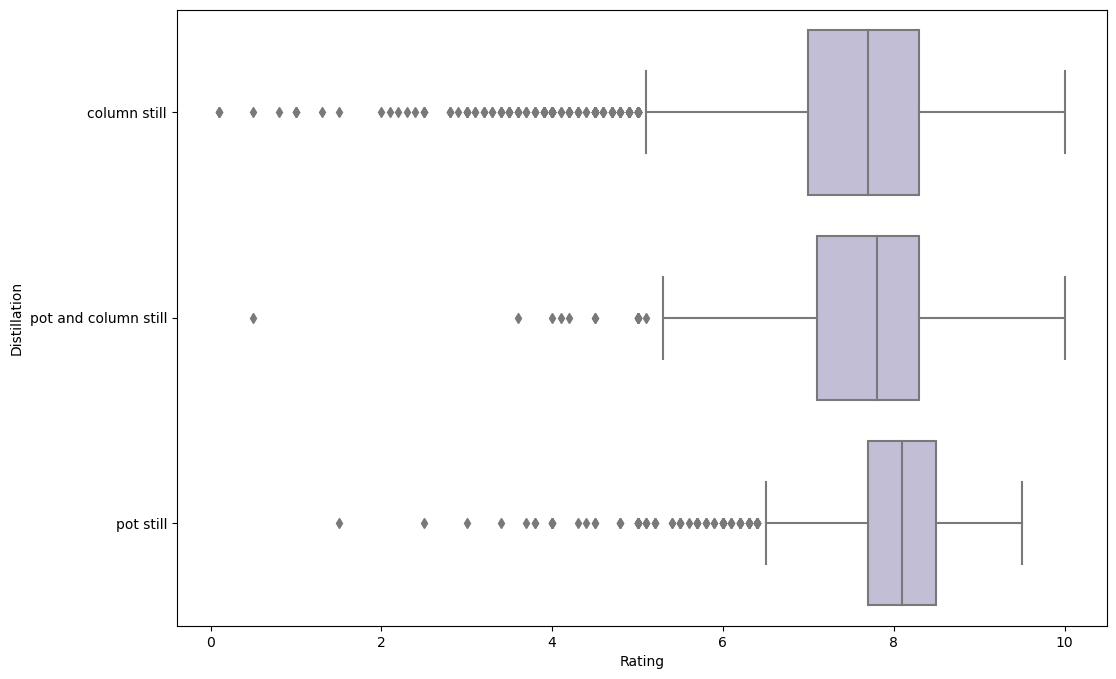

In [47]:
# set min observations
min_obs = 500
X_ = 'Distillation'
Y_ = 'Rating'

# subset data
rum_sub = rum[[X_, Y_]].dropna()
more_than_min = list(rum_sub[X_].value_counts()[rum_sub[X_].value_counts().values >= min_obs].index)
rum_sub = rum_sub[rum_sub[X_].isin(more_than_min)].dropna()

# get ordered index values
mean_by_x = rum[rum[X_].isin(more_than_min)].groupby([X_])[Y_].mean().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y=X_, x=Y_, data=rum_sub, color='#bebada', order=mean_by_x.index)
plt.show()

In [48]:
modelDist = ols(f"{Y_} ~ {X_}", data=rum_sub.dropna()).fit()
aov_tableDist = sm.stats.anova_lm(modelDist, typ=1)
aov_tableDist

,df,sum_sq,mean_sq,F,PR(>F)
Distillation,2.0,326.655945,163.327972,143.066774,1.472902e-61
Residual,6641.0,7581.502230,1.141621,NaN,NaN


**Looking at the ANOVA model output, we again see a low P-value indicating we reject the null hypothesis and conclude that there are differences in mean ratings between distillation types.**

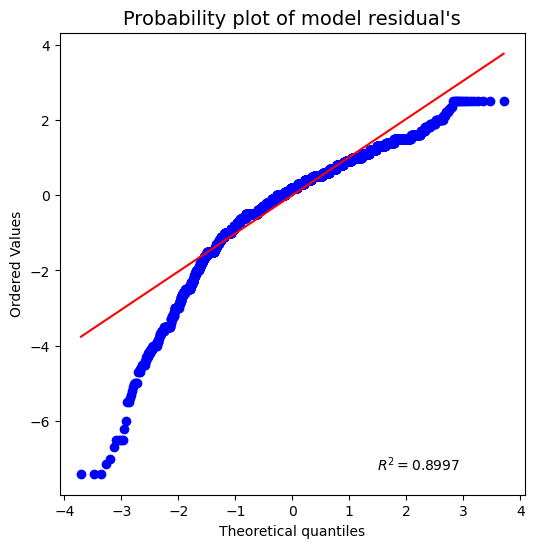


Levene Test for Variance P-Value: 1.3594483593383273e-34



In [49]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelDist.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()
levene_stat = stats.levene(rum_sub[Y_][rum_sub[X_] == 'pot still'].dropna(),
                           rum_sub[Y_][rum_sub[X_] == 'column still'].dropna(),
                           rum_sub[Y_][rum_sub[X_] == 'pot and column still'].dropna()
                           )
print('')
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')
print('')

**Looking at the QQ-plot and the Levene test, all assumptions fail for this analysis. The residuals deviate from a Normal distribution and the 3 groups have different variances. For curiosity's sake, I've included the Tukey-Pairwise test output below.**

In [50]:
rum_tukey_dist = rum[['Rating', 'Distillation']].dropna()
rum_tukey_dist = rum_tukey_dist[rum_tukey_dist['Distillation'].isin(['pot still', 'column still', 'pot and column still'])]

comp = mc.MultiComparison(rum_tukey_dist['Rating'], rum_tukey_dist['Distillation'])
tukey_dist = comp.tukeyhsd()
tukey_dist.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
column still,pot and column still,0.1433,0.0045,0.0371,0.2495,True
column still,pot still,0.5056,0.0,0.4355,0.5757,True
pot and column still,pot still,0.3623,0.0,0.2475,0.4771,True


***

**Next, we will look at the top 3 raw material sources (molasses, sugar cane, and blended) for differences in mean ratings.**

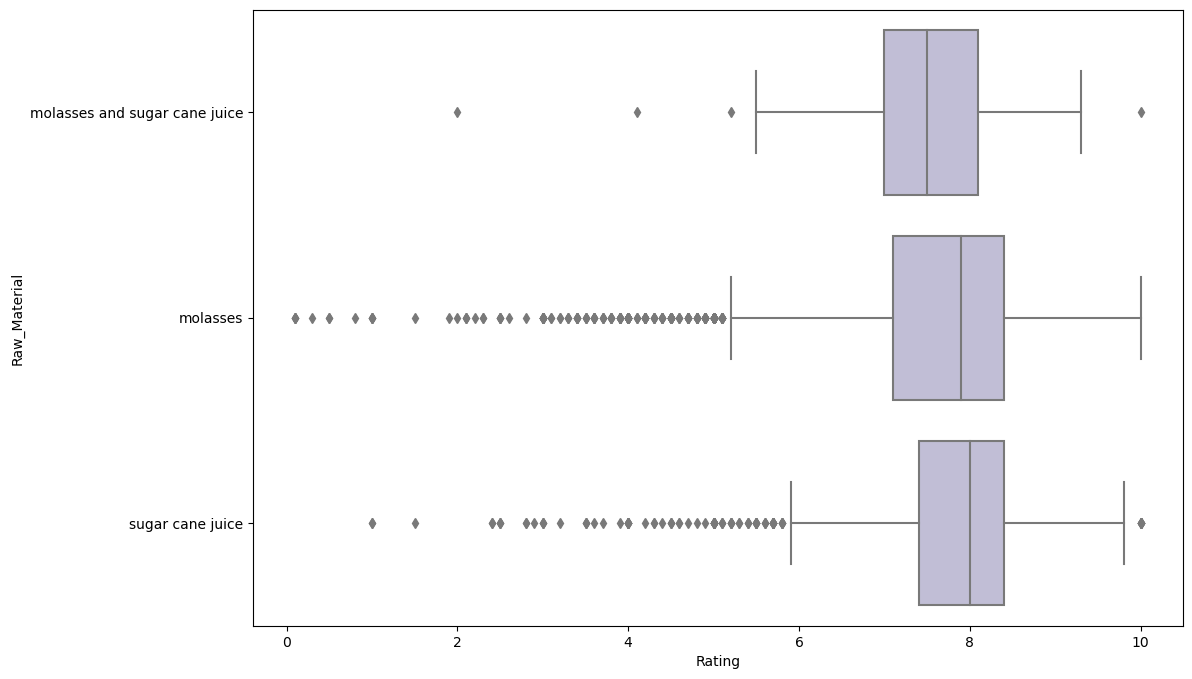

In [52]:
# set min observations
min_obs = 100
X_ = 'Raw_Material'
Y_ = 'Rating'

# subset data
rum_sub = rum[[X_, Y_]].dropna()
more_than_min = list(rum_sub[X_].value_counts()[rum_sub[X_].value_counts().values >= min_obs].index)
rum_sub = rum_sub[rum_sub[X_].isin(more_than_min)].dropna()

# get ordered index values
mean_by_x = rum[rum[X_].isin(more_than_min)].groupby([X_])[Y_].mean().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y=X_, x=Y_, data=rum_sub, color='#bebada', order=mean_by_x.index)
plt.show()

In [53]:
modelRaw = ols(f"{Y_} ~ {X_}", data=rum_sub.dropna()).fit()
aov_tableRaw = sm.stats.anova_lm(modelRaw, typ=1)
aov_tableRaw

,df,sum_sq,mean_sq,F,PR(>F)
Raw_Material,2.0,54.531890,27.265945,22.576115,1.650338e-10
Residual,9916.0,11975.891738,1.207734,NaN,NaN


**Once again, we see a test statistical and corresponding p-value indicating differences in means.**

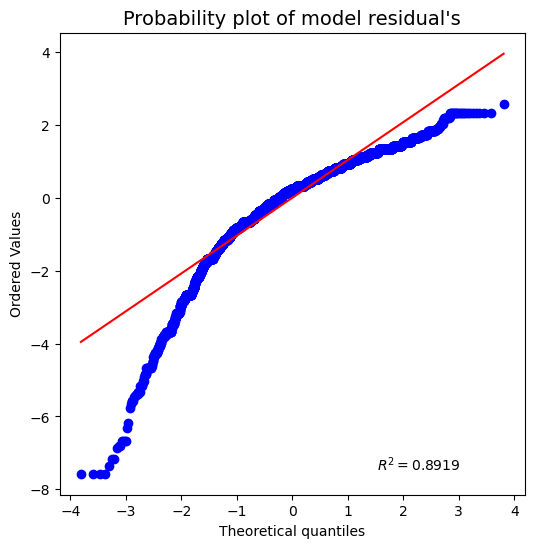

Levene Test for Variance P-Value: 3.8090447700879166e-14


In [54]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelRaw.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()
levene_stat = stats.levene(rum_sub[Y_][rum_sub[X_] == 'molasses and sugar cane juice'].dropna(),
                           rum_sub[Y_][rum_sub[X_] == 'molasses'].dropna(),
                           rum_sub[Y_][rum_sub[X_] == 'sugar cane juice'].dropna()
                           )
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')

**Looking at the QQ-plot and the Levene test, all assumptions fail for this analysis. The residuals deviate from a Normal distribution and the 3 groups have different variances. For curiosity's sake, I've included the Tukey-Pairwise test output below.**

In [56]:
rum_tukey_raw = rum[['Rating', 'Raw_Material']].dropna()
rum_tukey_raw = rum_tukey_raw[rum_tukey_raw['Raw_Material'].isin(['molasses', 'molasses and sugar cane juice', 'sugar cane juice'])]

comp = mc.MultiComparison(rum_tukey_raw['Rating'], rum_tukey_raw['Raw_Material'])
tukey_dist_raw = comp.tukeyhsd()
tukey_dist_raw.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
molasses,molasses and sugar cane juice,-0.2422,0.054,-0.4875,0.0032,False
molasses,sugar cane juice,0.1507,0.0,0.0932,0.2083,True
molasses and sugar cane juice,sugar cane juice,0.3929,0.0006,0.1447,0.6411,True


***

**Now I pivoted analysis into looking at multiple linear regression model to see what factors explain differences in ratings. As with ANOVA analysis we will also look at the 4 assumptions of linear regression:**

<ul>
  <li><b>Independent Observations</b></li>
  <li><b>Normally Distributed Residuals for Each Dependent Variable</b></li>
  <li><b>Linear Relationships Between Dependent and Independent Variavles</b></li>
  <li><b>Common Variance in the Residuals over the Range of the Dependent Variables</b></li>
</ul>

**Again, we have the same caveat with the independence assumption and are subsetting the data to the 6 countries, 3 distillation types, and 3 raw material types. I am only doing an inference analysis, no prediction. As such I will be using all data available and not splitting into training and testing.**

In [16]:
def AgeToNum(string):
    if pd.isna(string):
        return np.nan
    elif string == 'unaged':
        return 0
    else:
        return re.search(r'\d+', string).group()

countries = list(rum_price_adjust['Country'].value_counts().index[0:7])
distillations = ['pot still', 'column still', 'pot and column still']
raw_materials = ['molasses', 'molasses and sugar cane juice', 'sugar cane juice']

rum_major_subset = pd.read_csv('Data/rum.csv')
rum_major_subset = rum_major_subset[(rum_major_subset['Price'] <= 1000) & (rum_major_subset['Price'] > 10)]
rum_major_subset = rum_major_subset[rum_major_subset['Country'].isin(countries)]
rum_major_subset = rum_major_subset[rum_major_subset['Distillation'].isin(distillations)]
rum_major_subset = rum_major_subset[rum_major_subset['Raw_Material'].isin(raw_materials)]
rum_major_subset['Age'] = rum_major_subset['Age'].apply(AgeToNum)
rum_major_subset['Age'] = pd.to_numeric(rum_major_subset['Age'])
rum_major_subset.shape

(2685, 29)

**Before starting this analysis, we will do a little bit of data cleaning so we can use the age variable as a continuous variable. To do this, we extract the numbers from this otherwise string variable. Unaged rums were assigned an age of 0. We subset the data to include only the countries, distillation types, and raw matertial types outlined above.**

***

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     401.5
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          1.95e-207
Time:                        15:05:36   Log-Likelihood:                -1941.7
No. Observations:                2174   AIC:                             3891.
Df Residuals:                    2170   BIC:                             3914.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0161      0.079     76.535      0.0

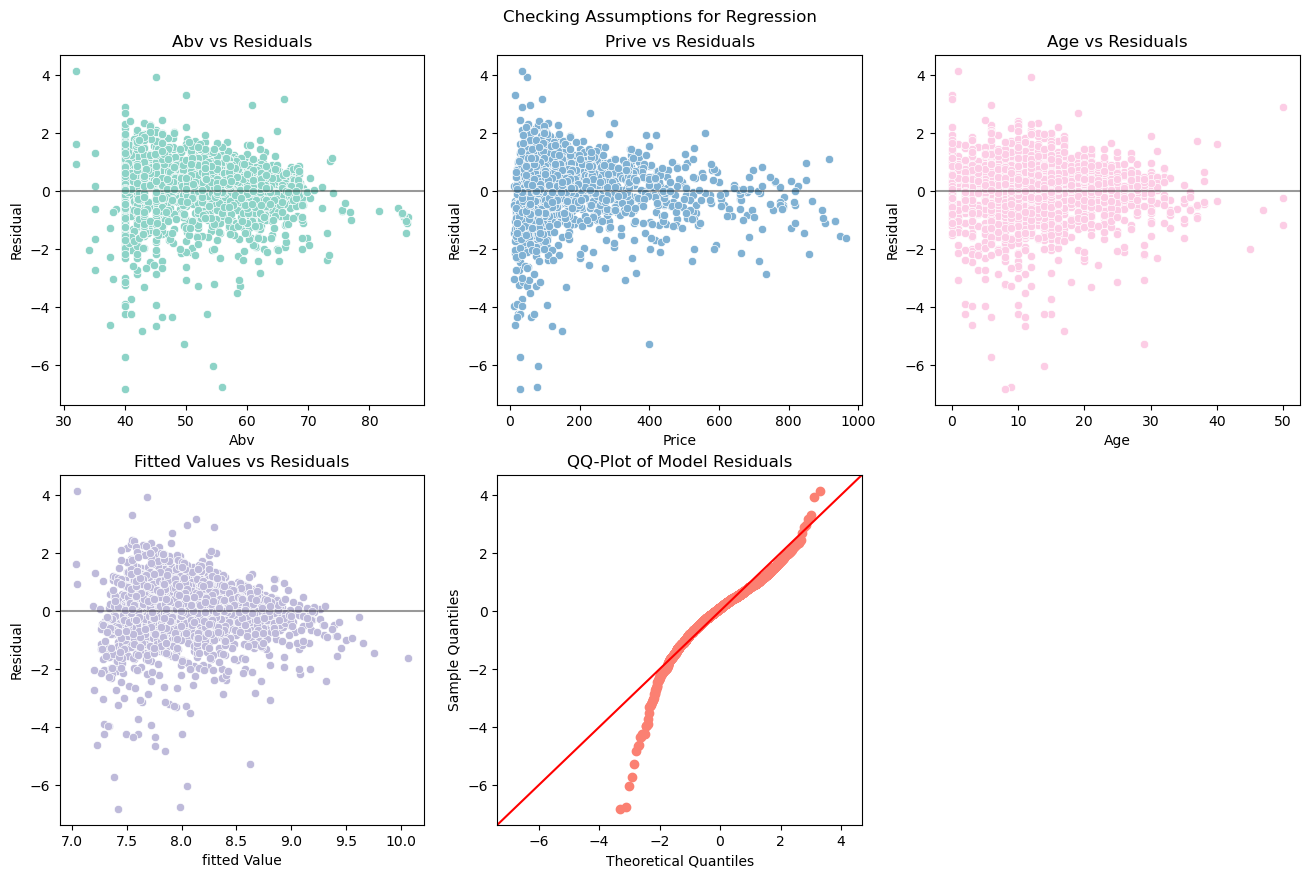

In [57]:
model_lin = sm.OLS.from_formula("Rating ~ Abv + Price + Age", data=rum_major_subset).fit()
std_resid = model_lin.resid / np.std(model_lin.resid)
print(model_lin.summary())

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

fig.suptitle('Checking Assumptions for Regression', y=.925)

sns.scatterplot(x=rum_major_subset['Abv'], y=std_resid, ax=axes[0,0], color='#8dd3c7', )
axes[0,0].axhline(y=0, color='black', alpha=0.4)
axes[0,0].set_title(f'Abv vs Residuals')
axes[0,0].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Price'], y=std_resid, ax=axes[0,1], color='#80b1d3')
axes[0,1].axhline(y=0, color='black', alpha=0.4)
axes[0,1].set_title(f'Prive vs Residuals')
axes[0,1].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Age'], y=std_resid, ax=axes[0,2], color='#fccde5', )
axes[0,2].axhline(y=0, color='black', alpha=0.4)
axes[0,2].set_title(f'Age vs Residuals')
axes[0,2].set_ylabel('Residual')

sns.scatterplot(x=model_lin.fittedvalues, y=std_resid, ax=axes[1,0], color='#bebada')
axes[1,0].axhline(y=0, color='black', alpha=0.4)
axes[1,0].set_title(f'Fitted Values vs Residuals')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('fitted Value')

sm.qqplot(std_resid, line ='45', ax=axes[1,1], markeredgecolor='#fb8072', markerfacecolor='#fb8072') 
axes[1,1].set_title(f'QQ-Plot of Model Residuals')

axes[-1, -1].axis('off')

plt.show()

**Our first simple model looks at rating as a function of alcohol by volume (ABV), price (Euros), and age (years). The model assumptions were investigated by looking at residual plots for each continuous independent variable, a fitted vs residual plot, and a QQ-plot of the residuals. From the model summary and plots above, we see that this model captured 35.6% of the variability in rating with the three independent variables. All three variables had a a significant p-value indicating that their coefficient was non-zero in this model. According to this model, each year of age was associated with an increase of 0.0204 rating and each unit of ABV was associated with an increase of 0.0302. Unfortunately, some of the model assumptions have some problems. Our QQ-plot shows clear deviation from normally distributed residuals, and each residual plot shows some heteroskedasticity. We will see if adding more variables and transforming the already included ones improve fit.**

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     19.88
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          4.83e-230
Time:                        15:28:55   Log-Likelihood:                -1416.7
No. Observations:                1976   AIC:                             3041.
Df Residuals:                    1872   BIC:                             3623.
Df Model:                         103                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

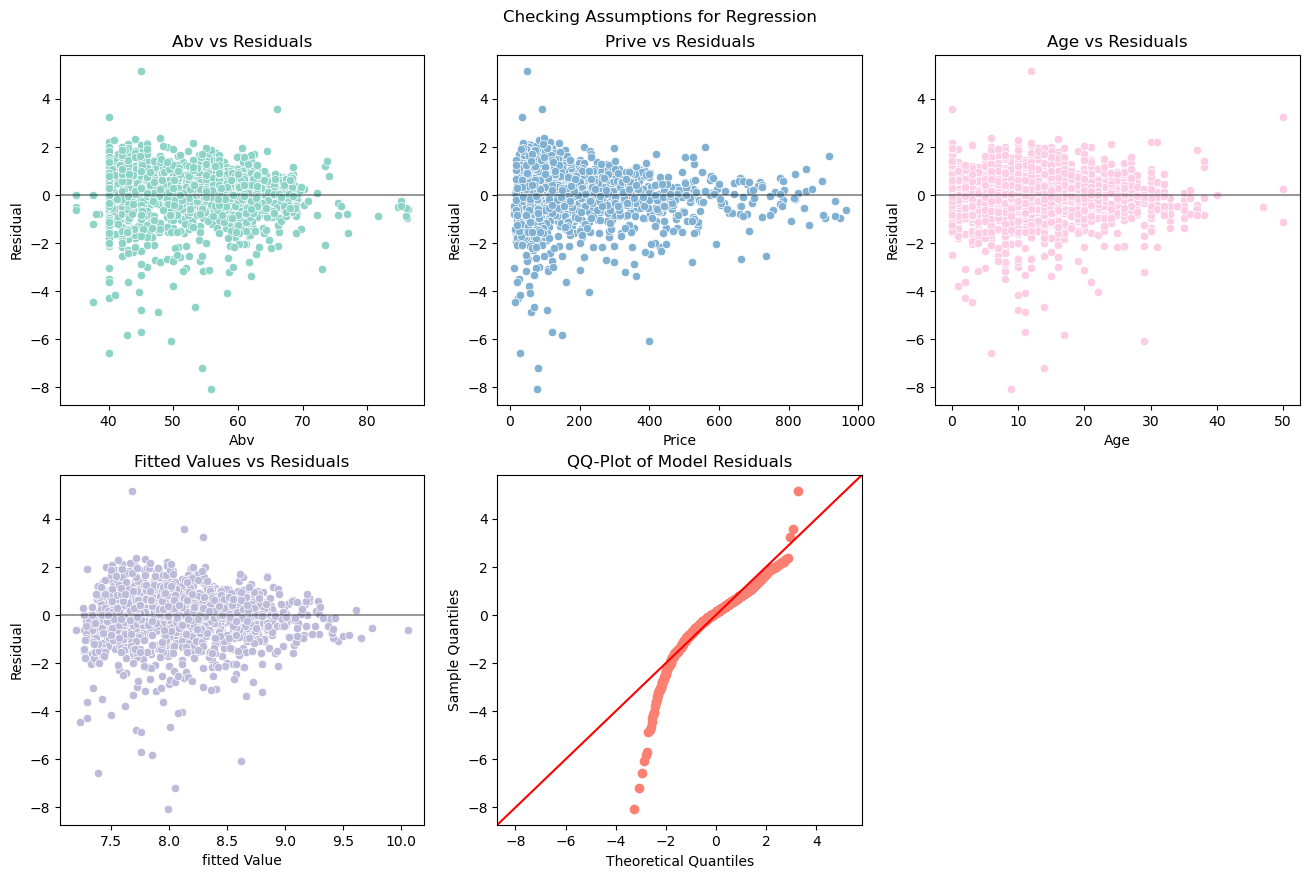

In [61]:
model_lin_power = sm.OLS.from_formula("Rating ~ np.sqrt(Abv) + np.log(Price) + Age + Country + Distillation + Raw_Material + Distillery", data=rum_major_subset).fit()
std_resid = model_lin_power.resid / np.std(model_lin_power.resid)
print(model_lin_power.summary())

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

fig.suptitle('Checking Assumptions for Regression', y=.925)

sns.scatterplot(x=rum_major_subset['Abv'], y=std_resid, ax=axes[0,0], color='#8dd3c7', )
axes[0,0].axhline(y=0, color='black', alpha=0.4)
axes[0,0].set_title(f'Abv vs Residuals')
axes[0,0].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Price'], y=std_resid, ax=axes[0,1], color='#80b1d3')
axes[0,1].axhline(y=0, color='black', alpha=0.4)
axes[0,1].set_title(f'Prive vs Residuals')
axes[0,1].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Age'], y=std_resid, ax=axes[0,2], color='#fccde5', )
axes[0,2].axhline(y=0, color='black', alpha=0.4)
axes[0,2].set_title(f'Age vs Residuals')
axes[0,2].set_ylabel('Residual')

sns.scatterplot(x=model_lin.fittedvalues, y=std_resid, ax=axes[1,0], color='#bebada')
axes[1,0].axhline(y=0, color='black', alpha=0.4)
axes[1,0].set_title(f'Fitted Values vs Residuals')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('fitted Value')

sm.qqplot(std_resid, line ='45', ax=axes[1,1], markeredgecolor='#fb8072', markerfacecolor='#fb8072') 
axes[1,1].set_title(f'QQ-Plot of Model Residuals')

axes[-1, -1].axis('off')

plt.show()

**I played around with a few transformations, but I found that taking the square root of ABV and the natural log of price improved linear fit. I also added country, distillation, distillery, and raw material categorical variables. Now the fit has improved to explain 49.6% of the variability in rating (by adjusted r-squared value). Once again, age, the square root of ABV, and the natural log of price were statistically significant from zero and had positive coefficients. Interestingly, no country or raw material, and only a few distilleries had significant coefficients. Unfortunately, the model fit wasn't great again when checking our residual and QQ-plots.**

                             OLS Regression Results                            
Dep. Variable:     np.power(Rating, 3)   R-squared:                       0.541
Model:                             OLS   Adj. R-squared:                  0.516
Method:                  Least Squares   F-statistic:                     21.46
Date:                 Mon, 11 Dec 2023   Prob (F-statistic):          7.82e-246
Time:                         15:33:37   Log-Likelihood:                -11642.
No. Observations:                 1976   AIC:                         2.349e+04
Df Residuals:                     1872   BIC:                         2.407e+04
Df Model:                          103                                         
Covariance Type:             nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

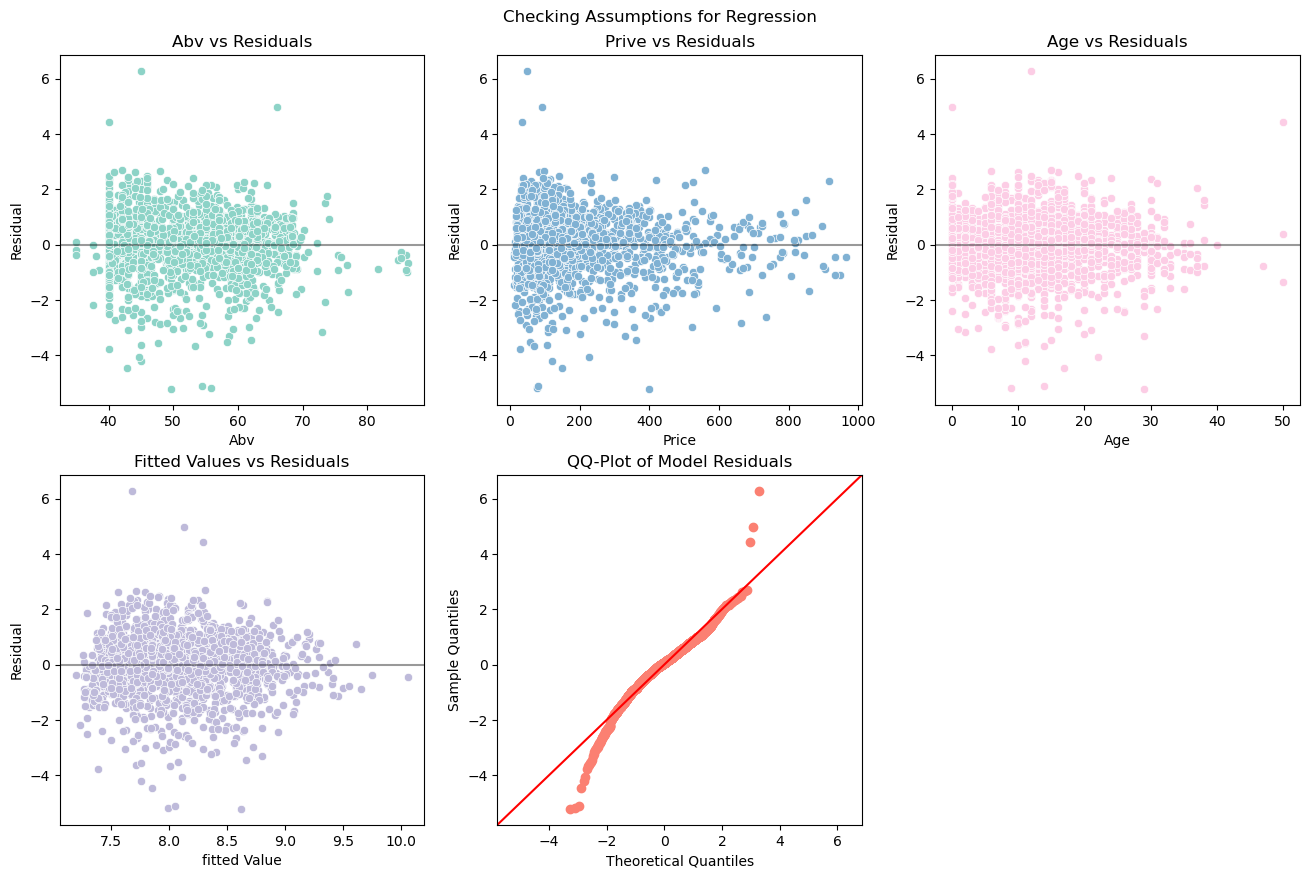

In [65]:
model_lin_power = sm.OLS.from_formula("np.power(Rating, 3) ~ np.sqrt(Abv) + np.log(Price) + Age + Country + Distillation + Raw_Material + Age + Distillery", data=rum_major_subset).fit()
std_resid = model_lin_power.resid / np.std(model_lin_power.resid)
print(model_lin_power.summary())

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

fig.suptitle('Checking Assumptions for Regression', y=.925)

sns.scatterplot(x=rum_major_subset['Abv'], y=std_resid, ax=axes[0,0], color='#8dd3c7', )
axes[0,0].axhline(y=0, color='black', alpha=0.4)
axes[0,0].set_title(f'Abv vs Residuals')
axes[0,0].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Price'], y=std_resid, ax=axes[0,1], color='#80b1d3')
axes[0,1].axhline(y=0, color='black', alpha=0.4)
axes[0,1].set_title(f'Prive vs Residuals')
axes[0,1].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Age'], y=std_resid, ax=axes[0,2], color='#fccde5', )
axes[0,2].axhline(y=0, color='black', alpha=0.4)
axes[0,2].set_title(f'Age vs Residuals')
axes[0,2].set_ylabel('Residual')

sns.scatterplot(x=model_lin.fittedvalues, y=std_resid, ax=axes[1,0], color='#bebada')
axes[1,0].axhline(y=0, color='black', alpha=0.4)
axes[1,0].set_title(f'Fitted Values vs Residuals')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('fitted Value')

sm.qqplot(std_resid, line ='45', ax=axes[1,1], markeredgecolor='#fb8072', markerfacecolor='#fb8072') 
axes[1,1].set_title(f'QQ-Plot of Model Residuals')

axes[-1, -1].axis('off')

plt.show()

**For the final model, I transformed the dependent variable by taking the cube of rating. This increased the explained variability to 51.6% and provided a better fit according to the homoskedasticity in the residual plots and linearity in the QQ-plot. The fit still isn't great, and this paired with the caveat of independence I mentioned earlier, I would take the results with a grain of salt.**

***

**A little disappointed in some of the failed assumptions of ANOVA and linear regression with rating models, I decided to explore the same analysis but with price as the independent variable. All the assumptions and caveats above also apply to this analysis.**

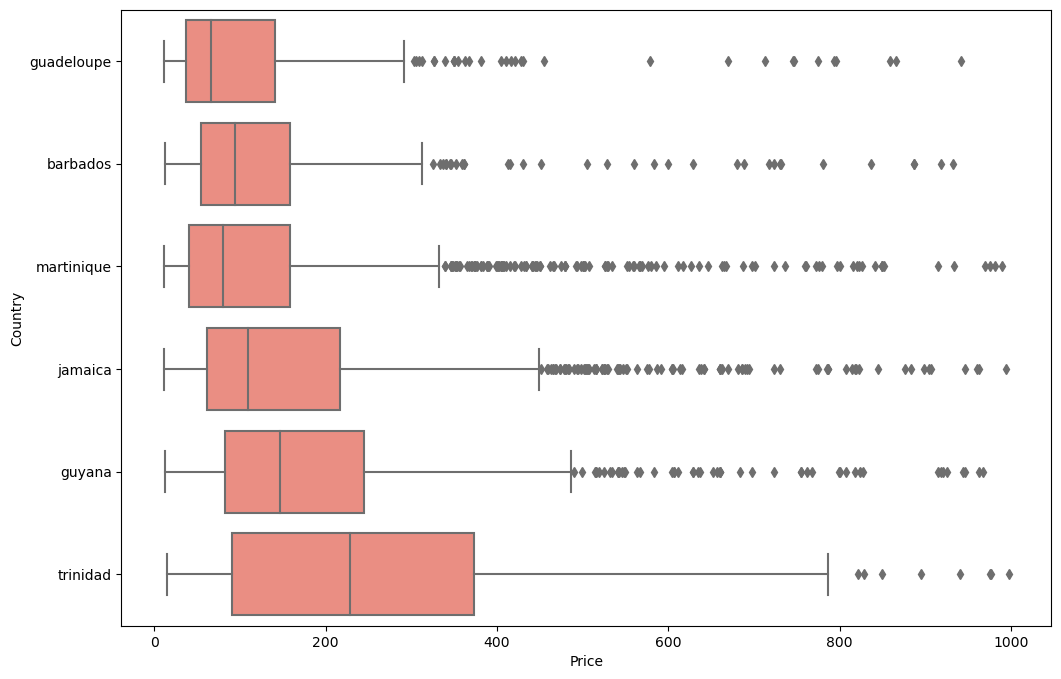

In [68]:
# set min observations
min_obs = 400

# subset data
rum_country_price = rum_price_adjust[['Country', 'Price']].dropna()
more_than_min = list(rum_country_price['Country'].value_counts()[rum_country_price['Country'].value_counts().values >= min_obs].index)
rum_country_price = rum_country_price[rum_country_price['Country'].isin(more_than_min)].dropna()

# get ordered index values
mean_by_country = rum_country_price[rum_country_price['Country'].isin(more_than_min)].groupby(['Country'])['Price'].mean().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y='Country', x='Price', data=rum_country_price, color='#fb8072', order=mean_by_country.index)
plt.show()

In [66]:
modelCountry = ols("np.log(Price) ~ Country", data=rum_country_price.dropna()).fit()
aov_tableCountry = sm.stats.anova_lm(modelCountry, typ=1)
aov_tableCountry

,df,sum_sq,mean_sq,F,PR(>F)
Country,5.0,314.381202,62.876240,76.31572,1.018954e-76
Residual,4110.0,3386.213856,0.823896,NaN,NaN


**The first thing I noticed while conducting an ANOVA test with price on the top 6 countries, was that the model performed better when the dependent variable was natural log transformed. Therefore, from here on all models will be conducted using the natural log of price. The p-value from the ANOVA table above indicates a statistically significant difference in at least one country with respect to log of price.**

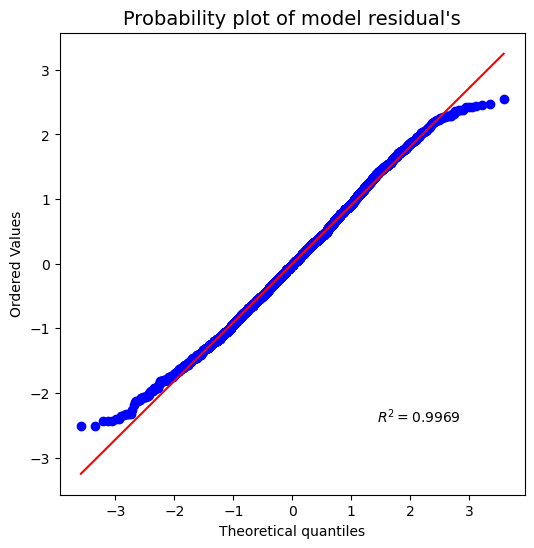

Levene Test for Variance P-Value: 0.8073544749326296


In [22]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelCountry.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()

levene_stat = stats.levene(rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'barbados'].dropna(),
             rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'guadeloupe'].dropna(),
             rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'martinique'].dropna(),
             rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'jamaica'].dropna(),
             rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'guyana'].dropna(),
             rum_price_adjust['Rating'][rum_price_adjust['Country'] == 'trinidad'].dropna()
             )
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')

**Looking at the QQ-plot of the residuals and the test statistic from the Levene test, we see an overall great fit. The QQ-plot is very linear with only slight deviation at either end, and the test statistic is not significant, meaning the variances in log price between groups are not different. As such, I feel more confident in these results than the ANOVA analysis on ratings. Using a Tukey test (below) we can find the statistically different pairs.**

In [23]:
rum_tukey_country = rum_price_adjust[['Rating', 'Country']].dropna()
rum_tukey_country = rum_tukey_country[rum_tukey_country['Country'].isin(['barbados', 'guadeloupe', 'martinique', 'jamaica', 'guyana', 'trinidad'])]

comp = mc.MultiComparison(rum_tukey_country['Rating'], rum_tukey_country['Country'])
tukey_country = comp.tukeyhsd()
tukey_country.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
barbados,guadeloupe,0.0107,1.0,-0.1396,0.161,False
barbados,guyana,0.1892,0.0009,0.054,0.3244,True
barbados,jamaica,0.1557,0.005,0.0311,0.2803,True
barbados,martinique,0.0704,0.5999,-0.0552,0.1961,False
barbados,trinidad,0.2237,0.0002,0.076,0.3714,True
guadeloupe,guyana,0.1785,0.004,0.0381,0.3189,True
guadeloupe,jamaica,0.145,0.0189,0.0148,0.2752,True
guadeloupe,martinique,0.0597,0.7868,-0.0715,0.191,False
guadeloupe,trinidad,0.213,0.001,0.0604,0.3655,True
guyana,jamaica,-0.0335,0.958,-0.146,0.0789,False


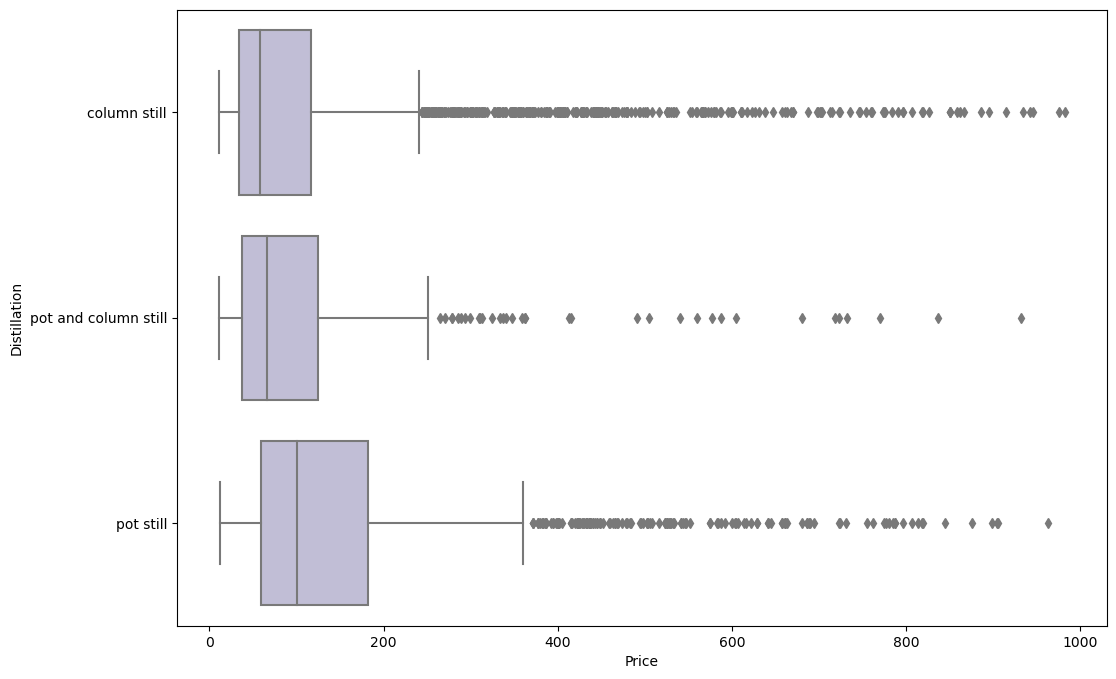

In [24]:
# set min observations
min_obs = 500
X_ = 'Distillation'
Y_ = 'Price'

# subset data
rum_sub = rum_price_adjust[[X_, Y_]].dropna()
more_than_min = list(rum_sub[X_].value_counts()[rum_sub[X_].value_counts().values >= min_obs].index)
rum_sub = rum_sub[rum_sub[X_].isin(more_than_min)].dropna()

# get ordered index values
mean_by_x = rum_price_adjust[rum_price_adjust[X_].isin(more_than_min)].groupby([X_])[Y_].median().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y=X_, x=Y_, data=rum_sub, color='#bebada', order=mean_by_x.index)
plt.show()

In [25]:
modelDist = ols(f"np.log({Y_}) ~ {X_}", data=rum_sub.dropna()).fit()
aov_tableDist = sm.stats.anova_lm(modelDist, typ=1)
aov_tableDist

,df,sum_sq,mean_sq,F,PR(>F)
Distillation,2.0,215.919424,107.959712,133.095668,4.653711e-57
Residual,5055.0,4100.331376,0.811144,NaN,NaN


**The ANOVA test statistic for log price and the 3 different types of distillation was also statistically significant.**

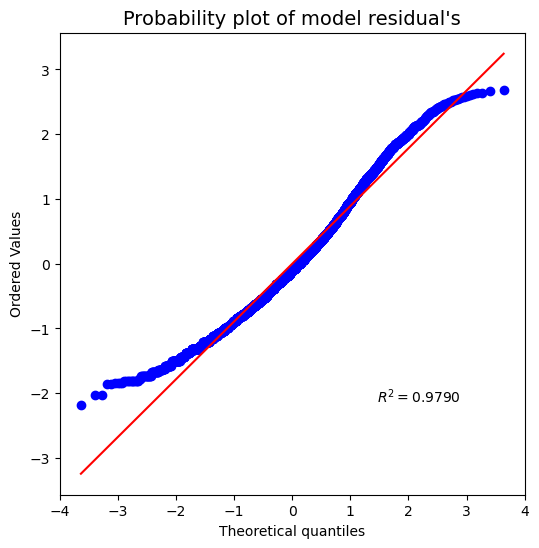

Levene Test for Variance P-Value: 0.001555971408459658


In [26]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelDist.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()
levene_stat = stats.levene(np.log(rum_sub[Y_][rum_sub[X_] == 'pot still']),
                           np.log(rum_sub[Y_][rum_sub[X_] == 'column still']),
                           np.log(rum_sub[Y_][rum_sub[X_] == 'pot and column still'])
                           )
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')

**Checking the assumptions, we see a slightly less linear QQ-plot of residuals, and the Levene test statistic shows that the 3 groups don't have the same variance. As such these results are less statistically meaningful.**

In [27]:
rum_tukey_dist = rum_price_adjust[['Rating', 'Distillation']].dropna()
rum_tukey_dist = rum_tukey_dist[rum_tukey_dist['Distillation'].isin(['pot still', 'column still', 'pot and column still'])]

comp = mc.MultiComparison(rum_tukey_dist['Rating'], rum_tukey_dist['Distillation'])
tukey_dist = comp.tukeyhsd()
tukey_dist.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
column still,pot and column still,0.1156,0.0306,0.0086,0.2227,True
column still,pot still,0.4754,0.0,0.4039,0.5469,True
pot and column still,pot still,0.3598,0.0,0.2445,0.475,True


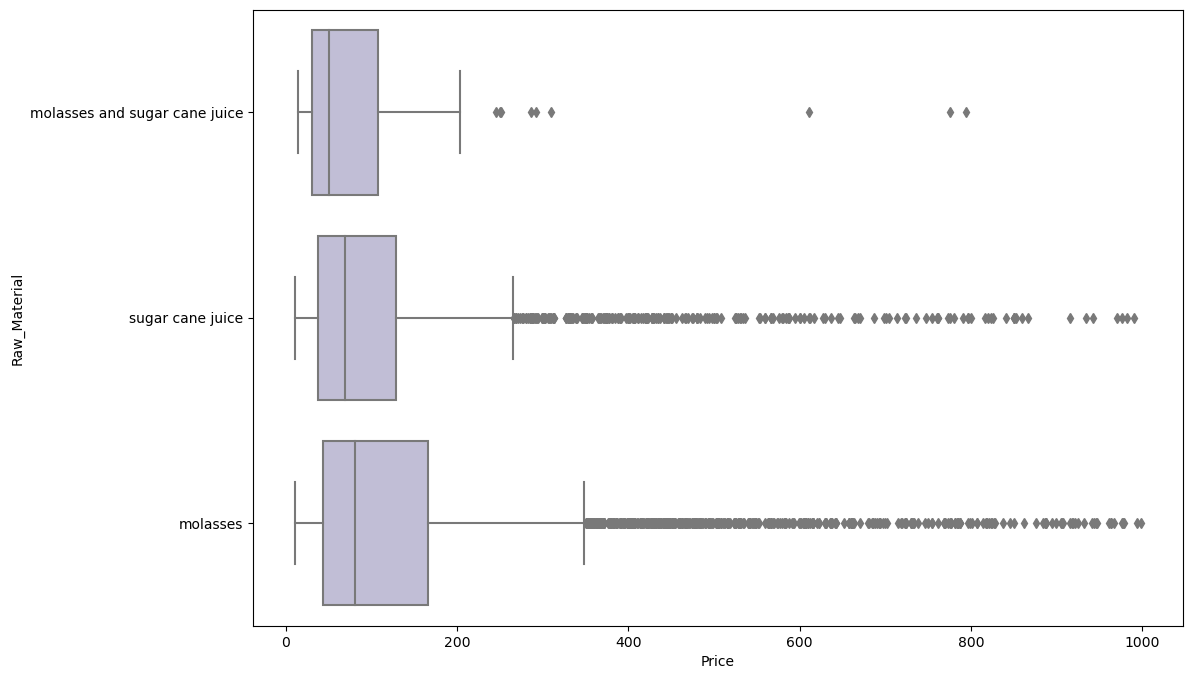

In [28]:
# set min observations
min_obs = 75
X_ = 'Raw_Material'
Y_ = 'Price'

# subset data
rum_sub = rum_price_adjust[[X_, Y_]].dropna()
more_than_min = list(rum_sub[X_].value_counts()[rum_sub[X_].value_counts().values >= min_obs].index)
rum_sub = rum_sub[rum_sub[X_].isin(more_than_min)].dropna()

# get ordered index values
mean_by_x = rum_price_adjust[rum_price_adjust[X_].isin(more_than_min)].groupby([X_])[Y_].mean().sort_values(ascending=True)

# mak plot
plt.figure(figsize=(12,8))
sns.boxplot(y=X_, x=Y_, data=rum_sub, color='#bebada', order=mean_by_x.index)
plt.show()

In [29]:
modelRaw = ols(f"np.log({Y_}) ~ {X_}", data=rum_sub.dropna()).fit()
aov_tableRaw = sm.stats.anova_lm(modelRaw, typ=1)
aov_tableRaw

,df,sum_sq,mean_sq,F,PR(>F)
Raw_Material,2.0,47.123303,23.561651,27.074556,1.929109e-12
Residual,7251.0,6310.187763,0.870251,NaN,NaN


**Finally, I looked at log price vs the 3 groups of raw materials. Again, the ANOVA test statistic is significant.**

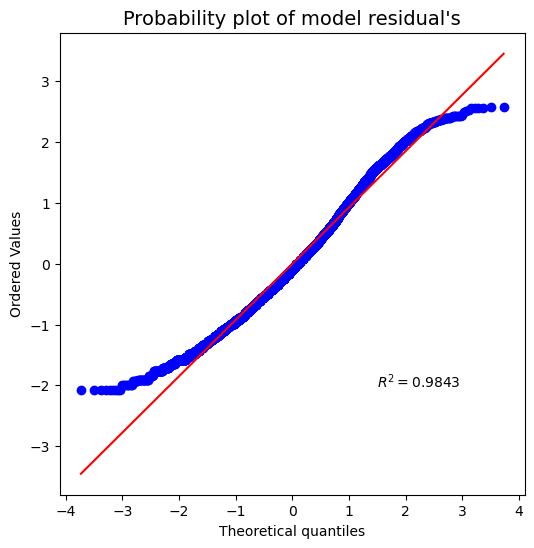

Levene Test for Variance P-Value: 0.11118837542306961


In [30]:
fig = plt.figure(figsize= (6, 6))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(modelRaw.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 14)
ax.set

plt.show()
levene_stat = stats.levene(np.log(rum_sub[Y_][rum_sub[X_] == 'molasses and sugar cane juice']).dropna(),
                           np.log(rum_sub[Y_][rum_sub[X_] == 'molasses']).dropna(),
                           np.log(rum_sub[Y_][rum_sub[X_] == 'sugar cane juice']).dropna()
                           )
print(f'Levene Test for Variance P-Value: {levene_stat.pvalue}')

**The QQ-plot of residuals shows decent linearity and the Levene test statistic was not significant. We can feel confident that the log price is different between at least 1 of the three groups, and we can see which ones specifically below.**

***

**Next, we will look at linear regression models for log price, as rating is not something that a distillery can control, I have not included it in these models. The first model I tried included the only two continuous variables (ABV and Age). We are are subsetting the data to the 6 countries, 3 distillation types, and 3 raw material types**

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     705.6
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          8.16e-237
Time:                        15:39:02   Log-Likelihood:                -2226.7
No. Observations:                2174   AIC:                             4459.
Df Residuals:                    2171   BIC:                             4476.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4246      0.089     27.297      0.0

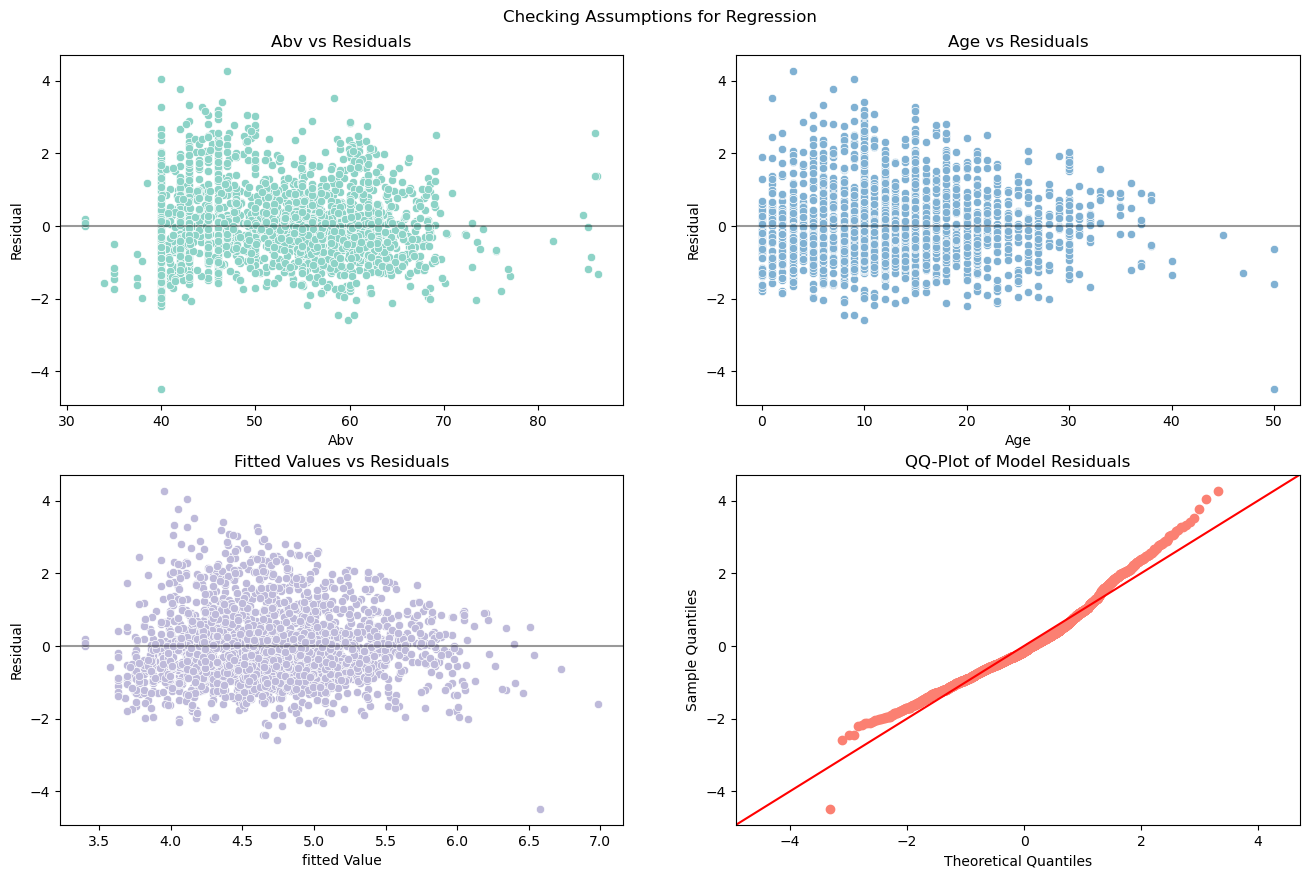

In [141]:
model_lin = sm.OLS.from_formula("np.log(Price) ~ Abv + Age", data=rum_major_subset).fit()
std_resid = model_lin.resid / np.std(model_lin.resid)
print(model_lin.summary())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

fig.suptitle('Checking Assumptions for Regression', y=.925)

sns.scatterplot(x=rum_major_subset['Abv'], y=std_resid, ax=axes[0,0], color='#8dd3c7', )
axes[0,0].axhline(y=0, color='black', alpha=0.4)
axes[0,0].set_title(f'Abv vs Residuals')
axes[0,0].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Age'], y=std_resid, ax=axes[0,1], color='#80b1d3')
axes[0,1].axhline(y=0, color='black', alpha=0.4)
axes[0,1].set_title(f'Age vs Residuals')
axes[0,1].set_ylabel('Residual')

sns.scatterplot(x=model_lin.fittedvalues, y=std_resid, ax=axes[1,0], color='#bebada')
axes[1,0].axhline(y=0, color='black', alpha=0.4)
axes[1,0].set_title(f'Fitted Values vs Residuals')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('fitted Value')

sm.qqplot(std_resid, line ='45', ax=axes[1,1], markeredgecolor='#fb8072', markerfacecolor='#fb8072') 
axes[1,1].set_title(f'QQ-Plot of Model Residuals')

plt.show()

**This model explains 39.3% of variation in the log price of rums meeting the country, distillation, and raw material criteria. Unlike the models for rating, the assumptions here are reasonably met. The QQ-plot shows much stronger linearity, the fitted value vs residual and feature vs residual plots don't show strong heteroskedasticity. Both ABV and Age were statistically significant with positive coefficients, indicating an increase in either results in an increase in the log price of a rum. The magnitude of the coefficient was greater for age than ABV.**

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.563
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     23.67
Date:                Fri, 08 Dec 2023   Prob (F-statistic):          2.60e-265
Time:                        15:43:41   Log-Likelihood:                -1679.5
No. Observations:                1976   AIC:                             3565.
Df Residuals:                    1873   BIC:                             4141.
Df Model:                         102                                         
Covariance Type:            nonrobust                                         
                                                      coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

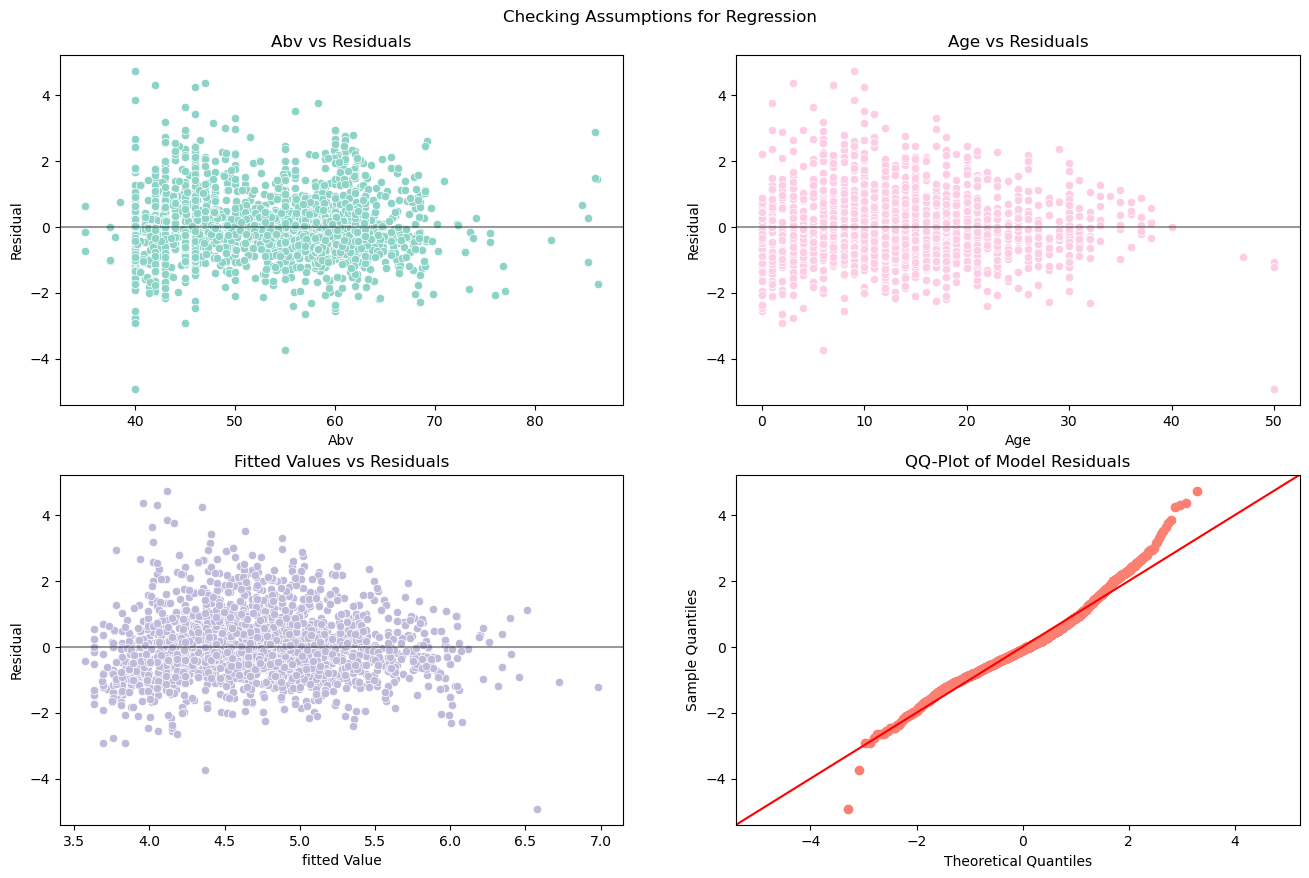

In [146]:
model_lin_power = sm.OLS.from_formula("np.log(Price) ~ Abv + Age + Country + Distillation + Raw_Material + Distillery", data=rum_major_subset).fit()
std_resid = model_lin_power.resid / np.std(model_lin_power.resid)
print(model_lin_power.summary())

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

fig.suptitle('Checking Assumptions for Regression', y=.925)

sns.scatterplot(x=rum_major_subset['Abv'], y=std_resid, ax=axes[0,0], color='#8dd3c7', )
axes[0,0].axhline(y=0, color='black', alpha=0.4)
axes[0,0].set_title(f'Abv vs Residuals')
axes[0,0].set_ylabel('Residual')

sns.scatterplot(x=rum_major_subset['Age'], y=std_resid, ax=axes[0,1], color='#fccde5', )
axes[0,1].axhline(y=0, color='black', alpha=0.4)
axes[0,1].set_title(f'Age vs Residuals')
axes[0,1].set_ylabel('Residual')

sns.scatterplot(x=model_lin.fittedvalues, y=std_resid, ax=axes[1,0], color='#bebada')
axes[1,0].axhline(y=0, color='black', alpha=0.4)
axes[1,0].set_title(f'Fitted Values vs Residuals')
axes[1,0].set_ylabel('Residual')
axes[1,0].set_xlabel('fitted Value')

sm.qqplot(std_resid, line ='45', ax=axes[1,1], markeredgecolor='#fb8072', markerfacecolor='#fb8072') 
axes[1,1].set_title(f'QQ-Plot of Model Residuals')

plt.show()

**Our final model looked at log price as a function of Abv, Age, Country, Distillation, Raw_Material, and Distillery (no transformations). In my opinion, this was the model that best fit the assumptions. The adjusted r-squared value was 0.539, meaning 53.9% variability explained by the model. The QQ-plot shows much stronger linearity, the fitted value vs residual and feature vs residual plots don't show strong heteroskedasticity.**

***

**Overall, gathering the data, building visuals, and then performing a few statistical tests to gain a deeper insight into the rum community's rum preferences was a ton of fun and I learned a ton. Specifically looking at this analysis, when examining the features that drive a rum's rating, a lot of the assumptions seemed to be violated. I believe this is in part due to the independence assumption, as well as the fact that rating is limited to values of 0 to 10 by values of 0.1. This makes it have many categorical features. This paired with the fact that higher order powers of rating started to produce better linear regression fits suggests that maybe a different model might perform better and should be looked at in future analysis. The log price of a rum was more easily modeled with linear regression and across all tests showed both age and ABV were associated with a statistically significant increase in a rum's log price (not groundbreaking stuff but suggests the models were working).**

**Future analysis will definitely be focused on looking at specific tasting notes and how those affect both rating and price. While this was only an exercise in inference, building a model to predict a rum's country of origin, from its tasting notes would also be a fun project!**